========Parameters for finite deformation========
Rf_max = 2.5632975628314902
Rf_min = 1.948197634189668
Wm_max = -0.4448399180802417
Wm_min = -0.9848231531811454
ΔA_max = -0.12310957610360374
ΔA_min = -0.2379021632852758
Rf_mean = 2.2526963339270525
Wm_mean = -0.6996276876262381
ΔA_mean = -0.19654779655700588
=========Parameters for Mohr circle========
R_mean = 0.3748582205701991
Q_mean = 0.2611815873734705
M_mean = 0.9357099398250366
R_max = 0.45685909990808876
R_min = 0.2965225527856216
Q_max = 0.32245066743532363
Q_min = 0.20287439428223006
M_max = 1.0216283891431013
M_min = 0.8744978282886784


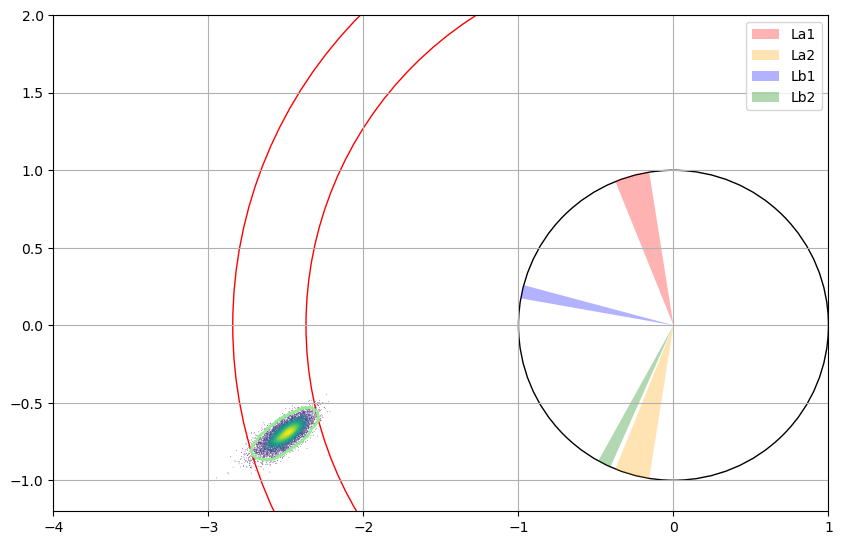

Statistics within the contour (within specified Rf range):
========Parameters for finite deformation=========
Rf_max = 2.458875882869351
Rf_min = 2.0860711320216594
Wm_max = -0.5317118662554111
Wm_min = -0.8675911716950497
ΔA_max = -0.15261818992538112
ΔA_min = -0.2237211284524394
Rf_mean = 2.258426796642015
Wm_mean = -0.6980983284543142
ΔA_mean = -0.1963904280917997
========Parameters for Mohr circle========
R_max = 0.4279316968448287
R_min = 0.3313904823908011
Q_max = 0.3011128529968468
Q_min = 0.2184737856096298
M_max = 0.9873419683097746
M_min = 0.8983472504993866
R_mean = 0.37525719353673265
Q_mean = 0.2610628678286636
M_mean = 0.936001315925092


C:\Users\n25-2\AppData\Local\Temp\ipykernel_30924\2422234574.py:303: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  path = contour.collections[0].get_paths()[0]  # Get the path of the first contour


In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.optimize as opt
from scipy.stats import gaussian_kde
from matplotlib.patches import Wedge

# ==============================
# User-defined parameters
# ==============================

# Angle ranges for La1, La2, Lb1, and Lb2 (in degrees)
La1_min = 29
La1_max = 33

La2_min = 132
La2_max = 141

Lb1_min = 0
Lb1_max = 0

Lb2_min = 142
Lb2_max = 142

# Range of finite strain (minimum and maximum Rf values)
Rf_min = 2.085
Rf_max = 2.459

# Number of trials (the larger the value, the higher the accuracy, but the longer the calculation time)
N = 10000

# Display range for the figure
x_min = -4.0
x_max = 1

y_min = -1.2
y_max = 2

# Plot size
size = 1

# ==============================
# Constants for calculations
# ==============================

T1 = (Rf_min + 1) / (Rf_min - 1)
T2 = (Rf_max + 1) / (Rf_max - 1)

# ==============================
# Initialize list for storing data
# ==============================

data_points = []  # List to store each data point (x0, y0, Rf, Wm, ΔA)

# ==============================
# Simulation functions
# ==============================

def generate_random_angle(min_val, max_val):
    """
    Generates a random angle based on a normal distribution within the specified range.
    Mean is set to (min + max) / 2, and standard deviation to (max - min) / 5.2.
    """
    mean = (max_val + min_val) / 2
    std_dev = (max_val - min_val) / 5.2
    return random.normalvariate(mean, std_dev)

def calculate_geometry(f_La1, f_La2, f_Lb1, f_Lb2):
    """
    Calculates geometric parameters from the angles.
    """
    # ==============================
    # Initial Angle and Radian Calculations
    # ==============================
    La1La2 = f_La2 - f_La1
    if La1La2 < 0:
        return None  # Skip if the condition is not met

    La1Lb1 = f_La1 - f_Lb1
    if La1Lb1 < 0:
        return None

    Lb1Lb2 = f_Lb1 + (180 - f_Lb2)
    if Lb1Lb2 < 0:
        return None

    # Convert to radians
    a = math.radians(La1La2)
    b = math.radians(La1Lb1 * 2)
    c = math.radians(Lb1Lb2 * 2)

    A0 = np.cos(a)

    # ==============================
    # Calculate Center Point (x0, y0)
    # ==============================
    x0, y0 = 0, 0 # Initialize to avoid reference errors
    try:
        # Check for division by zero before calculating k and l
        denom_k = (np.cos(a) - np.cos(a + b + c))
        denom_l = (np.cos(a) - np.cos(a + b))
        if denom_k == 0 or denom_l == 0:
            return None
            
        k = (np.sin(a) - np.sin(a + b + c)) / denom_k
        l = (-np.sin(a) - np.sin(a + b)) / denom_l

        # Define geometric points
        lb1_x = np.cos(a + b)
        lb1_y = np.sin(a + b)
        lb2_x = np.cos(a + b + c)
        lb2_y = np.sin(a + b + c)
        
        if b == 0:
            x0 = lb2_x + k * (lb2_y - lb1_y)
            y0 = -lb1_y
        else:
            if (k - l) == 0:
                return None # Avoid division by zero
            x0 = k * l * (-lb2_x / k + lb1_x / l - lb2_y + lb1_y) / (k - l)
            y0 = (lb2_x - lb1_x + k * lb2_y - l * lb1_y) / (k - l)

    except (ZeroDivisionError, ValueError):
        return None  # Skip if calculation fails

    # ==============================
    # Calculate Rf and Wm (now that x0, y0 are defined)
    # ==============================
    Ta = math.sqrt(x0 ** 2 + y0 ** 2)
    if Ta <= 1: # Rf would be negative or infinite
        return None
    
    Rf = (Ta + 1) / (Ta - 1)
    Wm = y0

    # ==============================
    # Calculate ΔA (Area)
    # This section was heavily corrected for syntax and execution errors.
    # The mathematical formulas are preserved but may need review.
    # ==============================
    dA = 0.0 # Default value in case of calculation failure
    try:
        if b > 0:
            def EQ_A_pos(r):
                if r == 0: return float('inf')
                xo1 = r * np.cos(a + b); xo2 = r * np.cos(a + b + c)
                yo1 = r * np.sin(a + b); yo2 = r * np.sin(a + b + c)
                qo = -(xo2 - xo1 + k*yo2 - l*yo1)/(k - l)
                mo = -k*l*(-xo2/k + xo1/l - yo2 + yo1)/(k - l)
                
                # Avoid math domain errors
                inner_sqrt = r**2 - qo**2
                if inner_sqrt < 0: return float('inf')
                no = (inner_sqrt)**(0.5)
                
                log_arg1 = mo + no
                log_arg2 = mo - no
                denom_log = math.log(log_arg1) - math.log(log_arg2) if log_arg2 > 0 else float('inf')
                if log_arg1 <= 0 or denom_log == 0: return float('inf')
                
                return no*(math.log(log_arg1) + math.log(log_arg2))/(r * denom_log) - A0

            r0 = opt.newton(EQ_A_pos, 0.001, maxiter=50)
            x10 = r0*np.cos(a+b); x20 = r0*np.cos(a+b+c)
            y10 = r0*np.sin(a+b); y20 = r0*np.sin(a+b+c)
            q0 = -(x20 - x10 + k*y20 - l*y10)/(k - l)
            m0 = -k*l*(-x20/k + x10/l - y20 + y10)/(k - l)
            to = (m0**2 + q0**2)**(1/2)
            Area = (to**2 - r0**2)-1 
            dA = Area

        elif b == 0:
            def EQ_A_zero(r):
                if r == 0: return float('inf')
                xo2 = r * np.cos(a + b + c)
                yo1 = r * np.sin(a + b); yo2 = r * np.sin(a + b + c)
                mo = -(xo2 + k*(yo2 - yo1))
                if mo <= 0: return float('inf')
                return mo * math.log(mo)/r - A0
            
            r0 = opt.newton(EQ_A_zero, 0.001, maxiter=50)
            x20 = r0*np.cos(a+b+c)
            y10 = r0*np.sin(a+b); y20 = r0*np.sin(a+b+c)
            q0 = -y10
            m0 = -(x20 + k*(y20 - y10))
            to = (m0**2 + q0**2)**(1/2)
            Area = (to**2 - r0**2)-1
            dA = Area

    except (RuntimeError, ZeroDivisionError, ValueError):
        return None

    # ==============================
    # Final return values
    # ==============================
    la1_x = np.cos(a)
    la1_y = np.sin(a)
    la2_x = np.cos(a)
    la2_y = -np.sin(a)
    # Re-calculate lb values to ensure they are available
    lb1_x = np.cos(a + b)
    lb1_y = np.sin(a + b)
    lb2_x = np.cos(a + b + c)
    lb2_y = np.sin(a + b + c)

    return x0, y0, la1_x, la1_y, la2_x, la2_y, lb1_x, lb1_y, lb2_x, lb2_y, dA, Rf, r0, q0, m0
    
def perform_simulation():
    """
    Executes the simulation and stores the results in the data array.
    """
    for i in range(N):
        # Generate random angles
        f_La1 = generate_random_angle(La1_min, La1_max)
        f_La2 = generate_random_angle(La2_min, La2_max)
        f_Lb1 = generate_random_angle(Lb1_min, Lb1_max)
        f_Lb2 = generate_random_angle(Lb2_min, Lb2_max)

        geometry = calculate_geometry(f_La1, f_La2, f_Lb1, f_Lb2)
        if geometry is None:
            continue  # Skip if condition is not met

        (x0, y0, la1_x, la1_y, la2_x, la2_y,
         lb1_x, lb1_y, lb2_x, lb2_y, dA, Rf, r0, q0, m0) = geometry

        # Add data to the list (x0, y0, Rf, Wm, ΔA, R, Q, M)
        data_points.append((x0, y0, Rf, y0, dA, r0, q0, m0))

def compute_statistics():
    """
    Calculates statistical data for all points.
    """
    x_values = [point[0] for point in data_points]
    y_values = [point[1] for point in data_points]
    Rf_values = [point[2] for point in data_points]
    Wm_values = [point[3] for point in data_points]
    Area_values = [point[4] for point in data_points]
    R_values = [point[5] for point in data_points]
    Q_values = [point[6] for point in data_points]
    M_values = [point[7] for point in data_points]

    # Calculate maximum and minimum values for each variable
    Rf_max = np.max(Rf_values)
    Rf_min = np.min(Rf_values)

    Wm_max = np.max(Wm_values)
    Wm_min = np.min(Wm_values)

    Area_max = np.max(Area_values)
    Area_min = np.min(Area_values)

    R_max = np.max(R_values)
    R_min = np.min(R_values)

    Q_max = np.max(Q_values)
    Q_min = np.min(Q_values)

    M_max = np.max(M_values)
    M_min = np.min(M_values)


    # Calculate mean values
    x_mean = np.mean(x_values)
    y_mean = np.mean(y_values)
    T_mean = math.sqrt(x_mean ** 2 + y_mean ** 2)
    Rf_mean = (T_mean + 1) / (T_mean - 1)
    Wm_mean = np.mean(Wm_values)
    Area_mean = np.mean(Area_values)
    R_mean = np.mean(R_values)
    Q_mean = np.mean(Q_values)
    M_mean = np.mean(M_values)

    print("========Parameters for finite deformation========")
    print('Rf_max =', Rf_max)
    print('Rf_min =', Rf_min)
    print('Wm_max =', Wm_max)
    print('Wm_min =', Wm_min)
    print('ΔA_max =', Area_max)
    print('ΔA_min =', Area_min)
    print('Rf_mean =', Rf_mean)
    print('Wm_mean =', Wm_mean)
    print('ΔA_mean =', Area_mean)
    print("=========Parameters for Mohr circle========")
    print('R_mean =', R_mean)
    print('Q_mean =', Q_mean)
    print('M_mean =', M_mean)
    print('R_max =', R_max)
    print('R_min =', R_min)
    print('Q_max =', Q_max)
    print('Q_min =', Q_min)
    print('M_max =', M_max)
    print('M_min =', M_min)
    



def filter_data_within_contour(contour, x_values, y_values):
    """
    Filters data points within the contour and within the specified Rf range.
    """
    path = contour.collections[0].get_paths()[0]  # Get the path of the first contour
    filtered_data = []
    for point, x, y in zip(data_points, x_values, y_values):
        if path.contains_point((x, y)) and Rf_min <= point[2] < Rf_max:
            filtered_data.append(point)
    return filtered_data

def compute_statistics_within_contour(filtered_data):
    """
    Calculates statistics for data points inside the contour and within the specified Rf range.
    """
    if not filtered_data:
        print("No data within the contour")
        return

    Rf_values = [point[2] for point in filtered_data]
    Wm_values = [point[3] for point in filtered_data]
    Area_values = [point[4] for point in filtered_data]
    R_values = [point[5] for point in filtered_data]
    Q_values = [point[6] for point in filtered_data]
    M_values = [point[7] for point in filtered_data]


    print("Statistics within the contour (within specified Rf range):")
    print("========Parameters for finite deformation=========")
    print('Rf_max =', np.max(Rf_values))
    print('Rf_min =', np.min(Rf_values))
    print('Wm_max =', np.max(Wm_values))
    print('Wm_min =', np.min(Wm_values))
    print('ΔA_max =', np.max(Area_values))
    print('ΔA_min =', np.min(Area_values))
    print('Rf_mean =', np.mean(Rf_values))
    print('Wm_mean =', np.mean(Wm_values))
    print('ΔA_mean =', np.mean(Area_values))
    
    print("========Parameters for Mohr circle========")
    print('R_max =', np.max(R_values))
    print('R_min =', np.min(R_values))
    print('Q_max =', np.max(Q_values))
    print('Q_min =', np.min(Q_values))
    print('M_max =', np.max(M_values))
    print('M_min =', np.min(M_values))
    print('R_mean =', np.mean(R_values))
    print('Q_mean =', np.mean(Q_values))
    print('M_mean =', np.mean(M_values))


def plot_results():
    """
    Plots the simulation results.
    """
    fig, ax = plt.subplots(figsize=(10, 10))

    x_values = [point[0] for point in data_points]
    y_values = [point[1] for point in data_points]

    # Color by kernel density estimation
    xy = np.vstack([x_values, y_values])
    z = gaussian_kde(xy)(xy)

    # Calculate the 95% density contour
    num_points = 100
    x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, num_points),
                                 np.linspace(y_min, y_max, num_points))
    z_grid = gaussian_kde(xy).evaluate(np.vstack([x_grid.ravel(), y_grid.ravel()])).reshape(x_grid.shape)

    # Set the density level corresponding to the 95% region
    z_max = np.max(z_grid)
    contour_levels = [z_max * 0.05]  # Level corresponding to the 95% density region

    contour = ax.contour(x_grid, y_grid, z_grid, levels=contour_levels, colors='lightgreen', linewidths=2)

    ax.scatter(x_values, y_values, c=z, marker=".", s=1, edgecolor='none')

    # Draw circles
    MC = patches.Circle(xy=(0, 0), radius=1, ec='#000000', fill=False)
    CT1 = patches.Circle(xy=(0, 0), radius=T1, ec='red', fill=False)
    CT2 = patches.Circle(xy=(0, 0), radius=T2, ec='red', fill=False)
    ax.add_patch(MC)
    ax.add_patch(CT1)
    ax.add_patch(CT2)

    # Set plot range and grid
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.grid()
    ax.set_aspect('equal')
    
    # Draw La1, La2, Lb1, Lb2 directions and wedges
    ax.add_patch(Wedge((0, 0), 1.0, La2_min-La1_max, La2_max-La1_min, facecolor='red', alpha=0.3, label='La1'))
    ax.add_patch(Wedge((0, 0), 1.0, -La2_max+La1_min, -La2_min+La1_max, facecolor='orange', alpha=0.3, label='La2'))
    ax.add_patch(Wedge((0, 0), 1.0, La2_min + La1_max - Lb1_max * 2, La2_max + La1_min - Lb1_min * 2, facecolor='blue', alpha=0.3, label='Lb1'))
    ax.add_patch(Wedge((0, 0), 1.0, La2_min + La1_max - Lb2_max * 2, La2_max + La1_min - Lb2_min * 2, facecolor='green', alpha=0.3, label='Lb2'))
    ax.legend()

    plt.show()

    # Filter data within the contour and calculate statistics
    filtered_data = filter_data_within_contour(contour, x_values, y_values)
    compute_statistics_within_contour(filtered_data)

# ==============================
# Main function
# ==============================

def main():
    """
    Main function. Executes the simulation and plots the results.
    """
    perform_simulation()

    # Display overall statistics
    compute_statistics()

    # Plot results and draw the density contour
    plot_results()

if __name__ == "__main__":
    main()
